In [5]:
import networkx as nx
import numpy as np

NODE_LABELS = 'feats'

In [7]:
from networkx.generators.random_graphs import erdos_renyi_graph


n = 6
p = 0.5
g = erdos_renyi_graph(n, p)

print(g.nodes)
print(g.edges)

[0, 1, 2, 3, 4, 5]
[(0, 1), (0, 3), (0, 4), (1, 3), (1, 5), (2, 4), (3, 5), (4, 5)]


In [71]:
def generate_graph_samples(initial_graph, number_of_graphs, num_node_classes, seed=42):
    # Seed
    sampled_graphs = []
    color_map = []
    graph = generate_one_graph_sample(initial_graph, seed)

    # generate random node features
    node_classes = np.random.randint(0, num_node_classes - 1, nx.number_of_nodes(initial_graph))

    feats = {k: v for k, v in enumerate(node_classes)}
    nx.set_node_attributes(graph, feats, NODE_LABELS)
    nx.draw(graph, with_labels = True)

    sampled_graphs.append(graph)

    for i in range(number_of_graphs - 1):
        sampled_graphs.append(permute_graph(graph, seed=i))

    return sampled_graphs

In [72]:
def generate_one_graph_sample(initial_graph, seed=42):
    degree_sequence = [d for n, d in initial_graph.degree()]
    sample_graph = nx.random_degree_sequence_graph(degree_sequence, seed=seed)

    return sample_graph

In [73]:
def permute_graph(graph, seed):
    list_nodes = list(graph.nodes())
    np.random.seed(seed)
    permuted_list_nodes = np.random.permutation(list_nodes)
    new_mapping = {i: j for i, j in zip(list_nodes, permuted_list_nodes)}
    H = nx.relabel_nodes(graph, new_mapping)

    return H

In [74]:
def generate_samples_of_n_classes(num_nodes, num_class, num_graphs_per_class, num_node_classes, p=0.15, seed=42):
    initial_graph = nx.generators.erdos_renyi_graph(num_nodes, p, seed)

    num_discarded_graphs = 0
    while not nx.is_connected(initial_graph):
        initial_graph = nx.generators.erdos_renyi_graph(num_nodes, p)
        # print(nx.number_connected_components(init_graph))
        num_discarded_graphs += 1
    print('number of discarded graphs: {}'.format(num_discarded_graphs))
    assert (nx.is_connected(initial_graph)), 'graph is not fully connected'

    dict_class_graphs = {}
    for i in range(num_class):
        list_graphs = generate_graph_samples(initial_graph, num_graphs_per_class, num_node_classes, seed=i)
        dict_class_graphs[i] = list_graphs

    return dict_class_graphs

In [75]:
def gen_iter_attributes_dict(nx_graph, num_features, seed=42, attr_name='node_label'):
    #    for i in df_nodes.label.unique():
    #        yield(i,df_nodes[df_nodes['label']==i].node.tolist())

    num_nodes = nx_graph.number_of_nodes()
    nodes = list(nx_graph.nodes())
    random_features = np.random.choice(range(num_features), num_nodes)

    for node, value in zip(nodes, random_features):
        yield (node, {attr_name: value})

In [76]:
def add_random_categorical_variables(nx_graph, num_features):
    nx_graph.add_nodes_from(gen_iter_attributes_dict(nx_graph, num_features))

In [77]:
def get_tensors(num_nodes_per_graph, num_graph_classes, num_node_classes, num_graphs_per_class):
    graph_dataset = generate_samples_of_n_classes(num_nodes=num_nodes_per_graph,
                                                  num_class=num_graph_classes,
                                                  num_node_classes=num_node_classes,
                                                  num_graphs_per_class=num_graphs_per_class)

    A = []
    X = []
    Y = []

    for n in range(num_graph_classes):
        for g_id in range(num_graphs_per_class):
            A.append(nx.to_numpy_array(graph_dataset[n][g_id], range(num_nodes_per_graph)))
            x_kv = nx.get_node_attributes(graph_dataset[n][g_id], NODE_LABELS )
            x = np.zeros([num_nodes_per_graph, num_node_classes])
            for r, c in x_kv.items():
                x[r, c] = 1
            X.append(x)

            Y.append(n)
    Y = np.array(Y).reshape([len(Y), 1])

    return np.array(A), np.array(X), Y

number of discarded graphs: 31


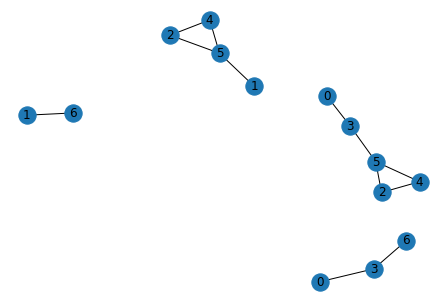

In [80]:
nx

In [ ]:
import numpy as np
from sklearn.model_selection import StratifiedShuffleSplit
from model.PiNet import PiNet
from analysis.experiment2 import generate
from model.GCNWithOptionalMean import GCNWithOptionalMean

from csv import writer